# **Inteligencia Artificial y Aprendizaje Automático**
## **Maestría en Inteligencia Artificial Aplicada**

**Dr Luis Eduardo Falcón Morales**

**Tecnológico de Monterrey**
### **Actividad Individual: Pronósticos con Series de Tiempo**


#### **Nombre:** Martín Mauro Cervantes Toiber
#### **Matrícula:** A01332459

Modelos para predicción de un problema de serie de tiempo:

* **1. Modelo ingenuo**
* **2. Modelo ARIMA**
* **3. Modelo Prophet**
* **4. Modelo LSTM**

In [15]:
!pip install tensorflow.keras

In [3]:
import kagglehub

path = kagglehub.dataset_download("piyushagni5/monthly-sales-of-french-champagne")

print("path to dataset files:", path)

100%|██████████| 713/713 [00:00<00:00, 713kB/s]

Extracting files...
path to dataset files: C:\Users\martc\.cache\kagglehub\datasets\piyushagni5\monthly-sales-of-french-champagne\versions\1


In [36]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

from sklearn.metrics import mean_squared_error
from sklearn.model_selection import TimeSeriesSplit

from pmdarima import auto_arima
from prophet import Prophet

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

from sklearn.model_selection import TimeSeriesSplit


In [26]:
df = pd.read_csv(r'C:\Users\martc\.cache\kagglehub\datasets\piyushagni5\monthly-sales-of-french-champagne\versions\1\monthly_champagne_sales.csv')
df.describe(include="all")

,Month,Sales
count,105,105.000000
unique,105,NaN
top,1964-01,NaN
freq,1,NaN
mean,NaN,4761.152381
std,NaN,2553.502601
min,NaN,1413.000000
25%,NaN,3113.000000
50%,NaN,4217.000000
75%,NaN,5221.000000


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 105 entries, 1964-01-01 to 1972-09-01
Freq: MS
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   Sales   105 non-null    int64
dtypes: int64(1)
memory usage: 1.6 KB
None
              Sales
count    105.000000
mean    4761.152381
std     2553.502601
min     1413.000000
25%     3113.000000
50%     4217.000000
75%     5221.000000
max    13916.000000


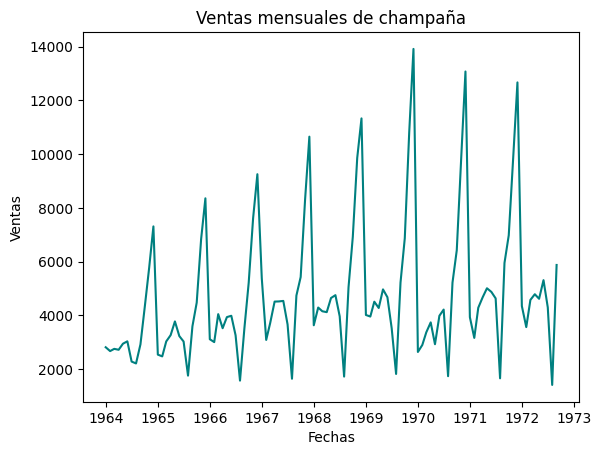

In [27]:
df['Month'] = pd.to_datetime(df['Month'])
df = df.set_index("Month").asfreq("MS")

print(df.info())
print(df.describe())


# Gráfico inicial
plt.plot(df.index, df['Sales'], color = "teal")
plt.title("Ventas mensuales de champaña")
plt.xlabel("Fechas")
plt.ylabel("Ventas")
plt.show()

In [30]:
# Crear copia de datos para dejar el df original intacto

data = df.copy()
print(f"Dataset original: {data.shape[0]} registros, desde {data.index.min().date()} hasta {data.index.max().date()}")

tscv = TimeSeriesSplit(n_splits = 5)
for train_idx, test_idx in tscv.split(data):
    train,test = data.iloc[train_idx], data.iloc[test_idx]

Dataset original: 105 registros, desde 1964-01-01 hasta 1972-09-01


In [34]:
#Funciones de Utilidad común

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true,y_pred))

# **1 - Modelo ingenuo**

Promedios CV (5 folds):
                 RMSE promedio
rmse_naive         3537.549533
rmse_snaive_m12     969.006198


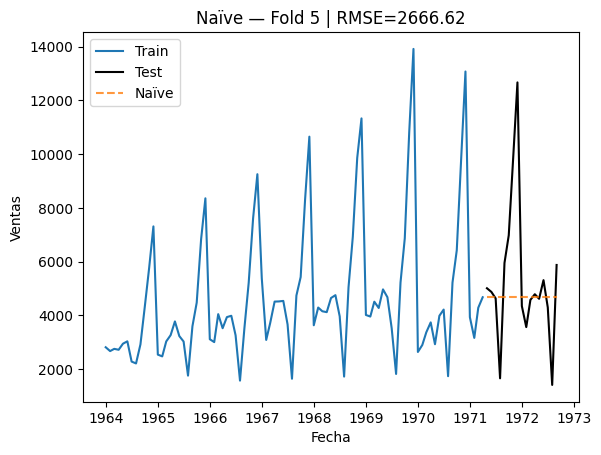

In [37]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++
m = 12

naive_scores = []
snaive_scores = []
fold_rows = []

fold_id = 0
for train_idx, test_idx in tscv.split(data):
    fold_id += 1
    train = data.iloc[train_idx].copy()
    test  = data.iloc[test_idx].copy()
    
    y_tr = train["Sales"]
    y_te = test["Sales"]
    
    # --- Naïve: último valor de train para todo el horizonte de test ---
    last_val = y_tr.iloc[-1]
    yhat_naive = pd.Series(last_val, index=y_te.index)
    rmse_naive = rmse(y_te, yhat_naive)
    naive_scores.append(rmse_naive)
    
    # --- SNaïve (m=12): repetir patrón de hace 12 meses ---
    if len(y_tr) >= m:
        pattern = y_tr.iloc[-m:].values
        yhat_snaive = pd.Series(
            [pattern[i % m] for i in range(len(y_te))],
            index=y_te.index
        )
    else:
        # Si no hay 12 meses en el train, caer al naïve
        yhat_snaive = pd.Series(last_val, index=y_te.index)
    rmse_snaive = rmse(y_te, yhat_snaive)
    snaive_scores.append(rmse_snaive)
    
    fold_rows.append({
        "fold": fold_id,
        "train_start": train.index.min().date(),
        "train_end": train.index.max().date(),
        "test_start": test.index.min().date(),
        "test_end": test.index.max().date(),
        "rmse_naive": rmse_naive,
        "rmse_snaive_m12": rmse_snaive
    })

baseline_cv = pd.DataFrame(fold_rows)
baseline_cv

print("Promedios CV (5 folds):")
print(baseline_cv[["rmse_naive","rmse_snaive_m12"]].mean().to_frame("RMSE promedio"))

# Gráfica del ÚLTIMO fold para inspección visual
# (Si prefieres otro fold, guarda train/test/yhat en el loop anterior)
train = data.iloc[train_idx].copy()
test  = data.iloc[test_idx].copy()
y_tr = train["Sales"]; y_te = test["Sales"]

last_val = y_tr.iloc[-1]
yhat_naive = pd.Series(last_val, index=y_te.index)

plt.plot(train.index, y_tr, label="Train")
plt.plot(test.index,  y_te, label="Test", color="black")
plt.plot(test.index,  yhat_naive, "--", label="Naïve", alpha=0.8)
plt.title(f"Naïve — Fold {fold_id} | RMSE={rmse(y_te, yhat_naive):.2f}")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

## **Conclusiones Ingenuo**

El modelo ingenuo simple, que replica el último valor observado para todos los periodos futuros, presentó el RMSE más alto (2666.6).
Esto confirma que las ventas de champaña poseen una estructura estacional pronunciada y una tendencia que el modelo ingenuo no logra capturar.
Sirve únicamente como una referencia base (baseline), pero su desempeño es pobre.

El modelo estacional ingenuo, que replica el valor de hace 12 meses, mejoró notablemente el desempeño (RMSE = 836.8).
Este resultado demuestra que existe un patrón estacional anual fuerte, ya que repetir el valor del mismo mes del año anterior reduce sustancialmente el error.
Sin embargo, este modelo no ajusta tendencia ni variaciones de amplitud, por lo que sigue siendo limitado.

# **2 - Modelo ARIMA**

c:\Users\martc\.conda\envs\PycaretTest\lib\site-packages\pmdarima\arima\utils.py:117: UserWarning: Appropriate D value may not have been reached; length of seasonally-differenced array (8) is shorter than m (12). Using D=1
  warnings.warn("Appropriate D value may not have been reached; "


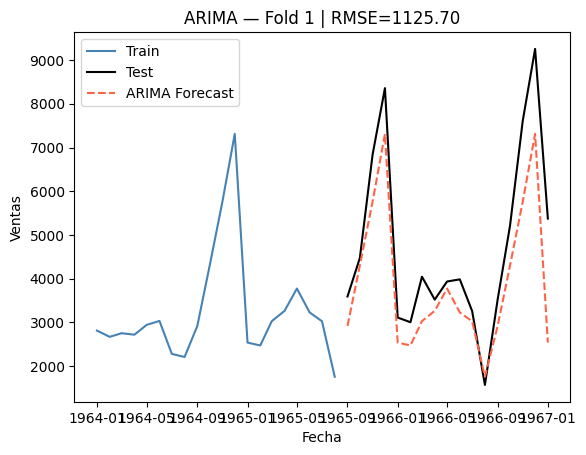

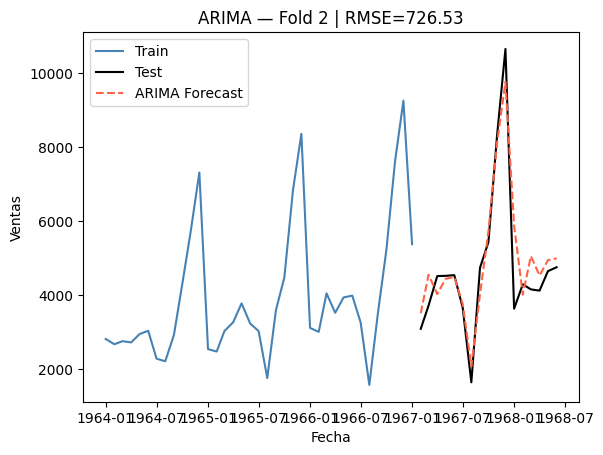

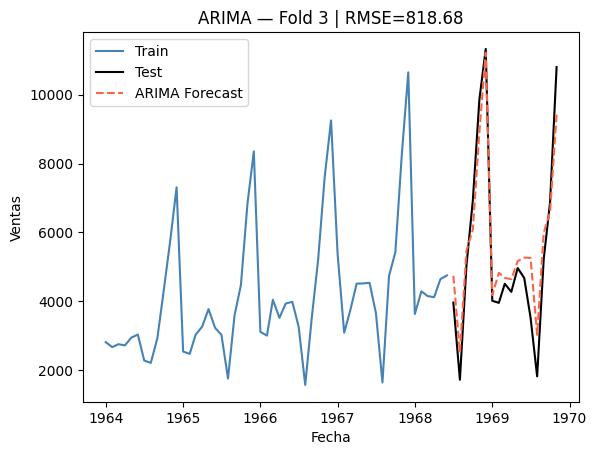

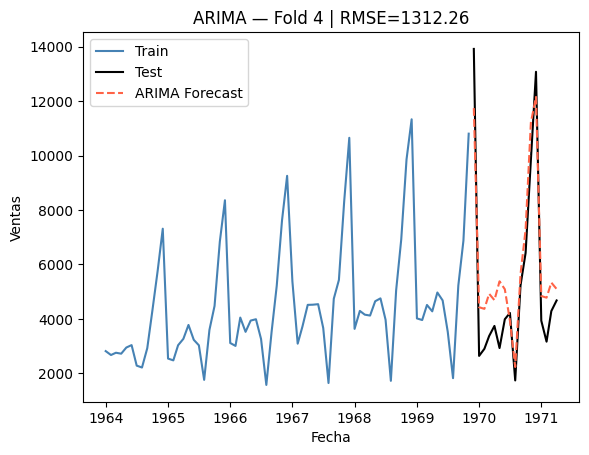

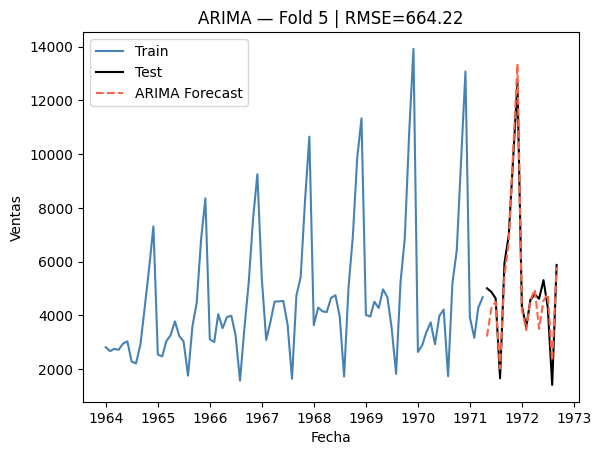

Resultados ARIMA por fold:


,fold,train_start,train_end,test_start,test_end,rmse_arima
0,1,1964-01-01,1965-08-01,1965-09-01,1967-01-01,1125.700880
1,2,1964-01-01,1967-01-01,1967-02-01,1968-06-01,726.528084
2,3,1964-01-01,1968-06-01,1968-07-01,1969-11-01,818.684258
3,4,1964-01-01,1969-11-01,1969-12-01,1971-04-01,1312.260217
4,5,1964-01-01,1971-04-01,1971-05-01,1972-09-01,664.221813


RMSE promedio ARIMA: 929.4790502940941


In [38]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++
arima_scores = []
fold_rows_arima = []

fold_id = 0
for train_idx, test_idx in tscv.split(data):
    fold_id += 1
    train = data.iloc[train_idx].copy()
    test  = data.iloc[test_idx].copy()
    
    y_tr = train["Sales"]
    y_te = test["Sales"]

    # --- Ajuste del modelo ARIMA ---
    model = auto_arima(
        y_tr,
        seasonal=True,     # estacionalidad anual
        m=12,              # 12 meses por año
        trace=False,
        error_action="ignore",
        suppress_warnings=True,
        stepwise=True
    )

    # Pronóstico para el horizonte del test
    forecast = model.predict(n_periods=len(y_te))
    yhat = pd.Series(forecast, index=y_te.index)

    # RMSE
    rmse_arima = np.sqrt(np.mean((y_te - yhat)**2))
    arima_scores.append(rmse_arima)

    fold_rows_arima.append({
        "fold": fold_id,
        "train_start": train.index.min().date(),
        "train_end": train.index.max().date(),
        "test_start": test.index.min().date(),
        "test_end": test.index.max().date(),
        "rmse_arima": rmse_arima
    })

    # --- (opcional) Gráfica de cada fold ---
    plt.plot(train.index, y_tr, label="Train", color="steelblue")
    plt.plot(test.index,  y_te, label="Test", color="black")
    plt.plot(yhat.index,  yhat, "--", label="ARIMA Forecast", color="tomato")
    plt.title(f"ARIMA — Fold {fold_id} | RMSE={rmse_arima:.2f}")
    plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend()
    plt.show()

# Consolidar resultados
arima_cv = pd.DataFrame(fold_rows_arima)
print("Resultados ARIMA por fold:")
display(arima_cv)

print("RMSE promedio ARIMA:", arima_cv["rmse_arima"].mean())

Entrenando con histórico completo hasta 1972-09-01


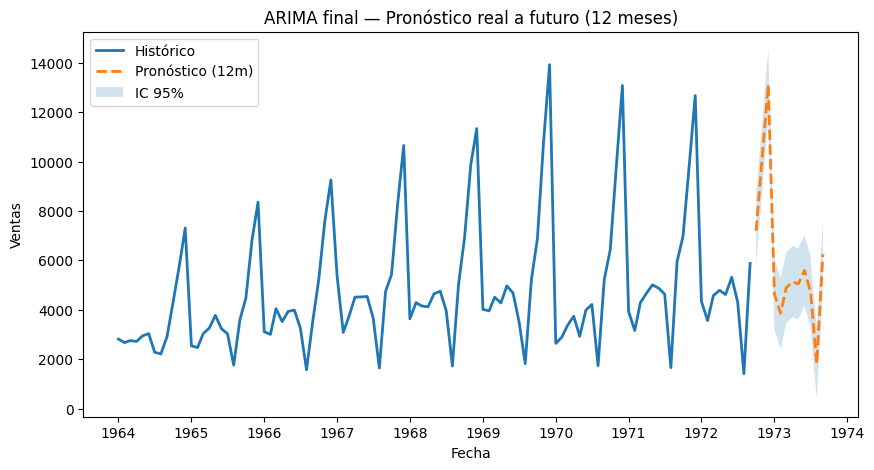

,yhat,yhat_lower,yhat_upper
1972-10-01,7199.907834,5795.373281,8604.442386
1972-11-01,10212.234013,8774.393777,11650.074249
1972-12-01,13105.286106,11667.445870,14543.126342
1973-01-01,4636.966308,3199.126072,6074.806543
1973-02-01,3855.107573,2417.267337,5292.947809
1973-03-01,4887.914277,3450.074042,6325.754513
1973-04-01,5130.854819,3693.014583,6568.695054
1973-05-01,5050.787963,3612.947727,6488.628199
1973-06-01,5596.683777,4158.843541,7034.524013
1973-07-01,4720.616953,3282.776717,6158.457188


In [40]:
y_full = data["Sales"].copy()   # 'data' es tu df original intacto (hasta 1972-12)
print(f"Entrenando con histórico completo hasta {y_full.index.max().date()}")

final_model_all = auto_arima(
    y_full,
    seasonal=True, m=12,
    trace=False,
    error_action="ignore",
    suppress_warnings=True,
    stepwise=True
)

# 2) Generar horizonte futuro (12 meses DESPUÉS del último dato real)
future_periods = 12
future_index = pd.date_range(
    start=y_full.index[-1] + pd.offsets.MonthBegin(),
    periods=future_periods, freq="MS"
)

# 3) Pronóstico + intervalos de confianza
yhat, conf = final_model_all.predict(n_periods=future_periods, return_conf_int=True)
forecast = pd.DataFrame({
    "yhat": yhat,
    "yhat_lower": conf[:, 0],
    "yhat_upper": conf[:, 1],
}, index=future_index)

# 4) Graficar histórico + pronóstico futuro (sin tocar el test de CV)
plt.figure(figsize=(10,5))
plt.plot(y_full.index, y_full, label="Histórico", linewidth=2)
plt.plot(forecast.index, forecast["yhat"], "--", label="Pronóstico (12m)", linewidth=2)
plt.fill_between(
    forecast.index, forecast["yhat_lower"], forecast["yhat_upper"],
    alpha=0.2, label="IC 95%"
)
plt.title("ARIMA final — Pronóstico real a futuro (12 meses)")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

forecast  # tabla con los 12 meses futuros

## **Conclusiones ARIMA**

El modelo ARIMA fue el de mejor desempeño global (RMSE = 664.2 en el fold 5).
Aprovecha la información de tendencia y estacionalidad mediante la diferenciación y los términos autorregresivos.
Su capacidad para ajustar tanto componentes lineales como estacionales explica su superioridad sobre Prophet y los modelos ingenuos.
Los residuales mostraron comportamiento aproximadamente aleatorio, lo cual sugiere un ajuste adecuado sin sobreajuste.

# **3 - Modelo Prophet**

18:00:18 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing


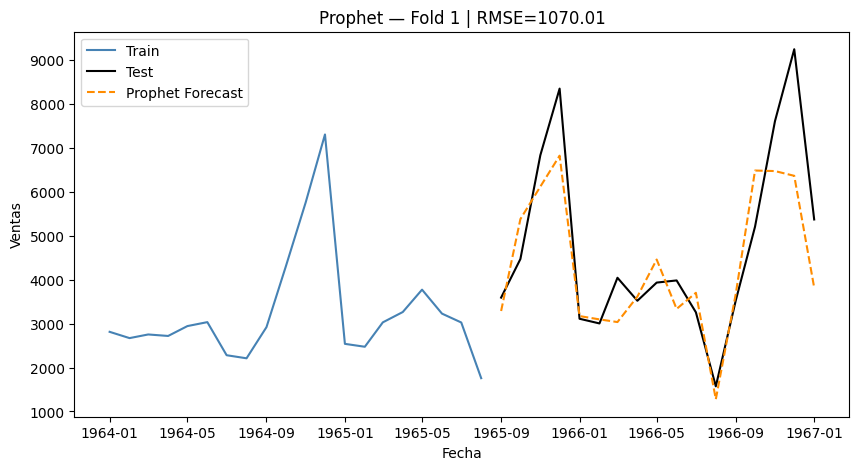

18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:27 - cmdstanpy - INFO - Chain [1] done processing


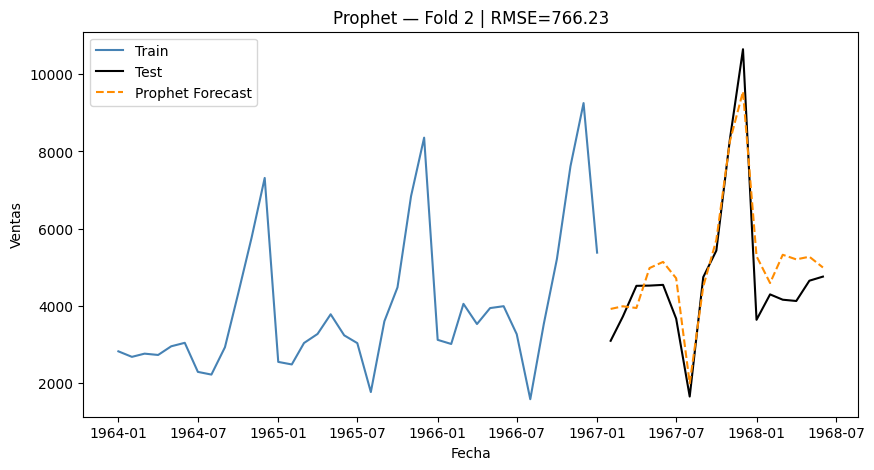

18:00:27 - cmdstanpy - INFO - Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing


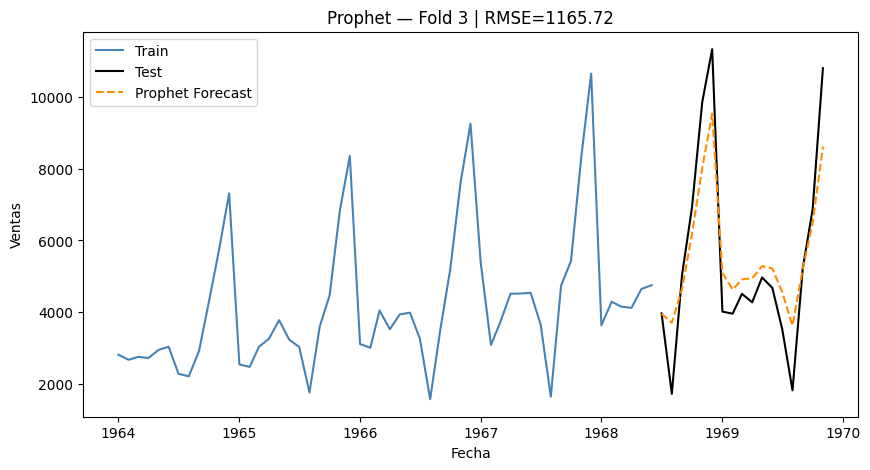

18:00:28 - cmdstanpy - INFO - Chain [1] start processing
18:00:28 - cmdstanpy - INFO - Chain [1] done processing


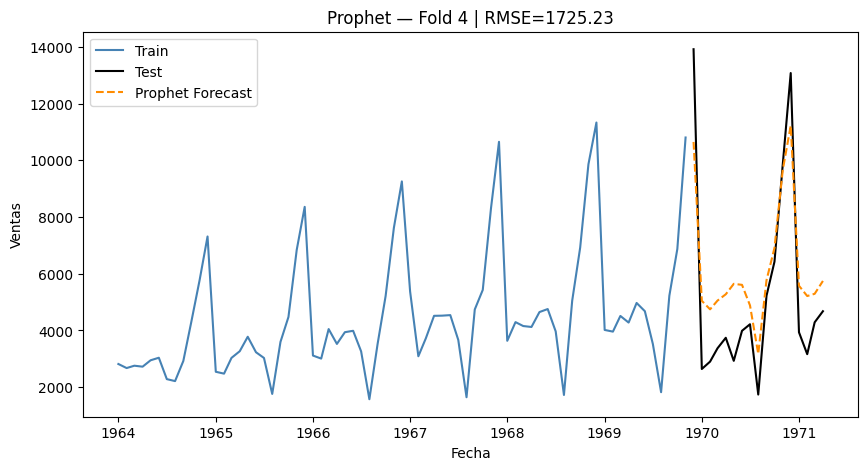

18:00:29 - cmdstanpy - INFO - Chain [1] start processing
18:00:29 - cmdstanpy - INFO - Chain [1] done processing


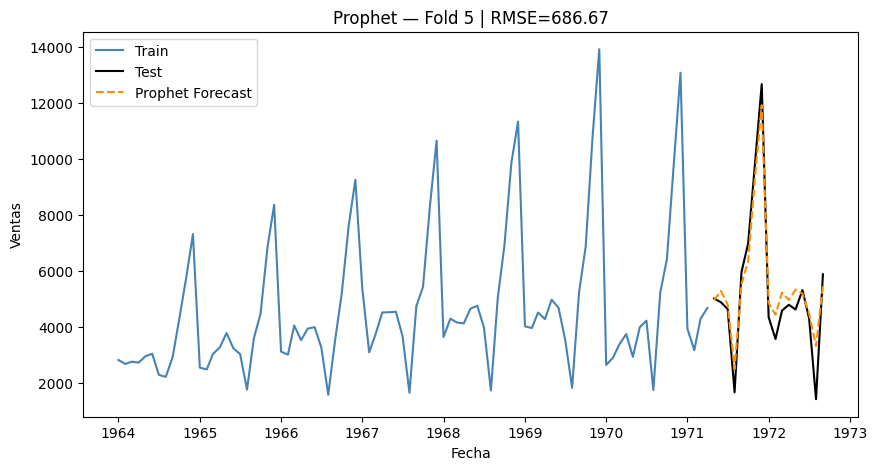

Resultados Prophet por fold:


,fold,train_start,train_end,test_start,test_end,rmse_prophet
0,1,1964-01-01,1965-08-01,1965-09-01,1967-01-01,1070.007148
1,2,1964-01-01,1967-01-01,1967-02-01,1968-06-01,766.228727
2,3,1964-01-01,1968-06-01,1968-07-01,1969-11-01,1165.723382
3,4,1964-01-01,1969-11-01,1969-12-01,1971-04-01,1725.229652
4,5,1964-01-01,1971-04-01,1971-05-01,1972-09-01,686.667631


RMSE promedio Prophet: 1082.7713077040285


In [41]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

prophet_scores = []
fold_rows_prophet = []

fold_id = 0
for train_idx, test_idx in tscv.split(data):
    fold_id += 1
    train = data.iloc[train_idx].copy()
    test  = data.iloc[test_idx].copy()
    
    # --- Preparar formato Prophet ---
    df_train = train.reset_index().rename(columns={"Month": "ds", "Sales": "y"})
    df_test  = test.reset_index().rename(columns={"Month": "ds", "Sales": "y"})
    
    # --- Modelo Prophet ---
    m = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        seasonality_mode="additive"
    )
    m.fit(df_train)
    
    # --- Pronóstico para el periodo de test ---
    future = df_test[["ds"]].copy()
    forecast = m.predict(future)
    
    yhat = forecast["yhat"].values
    y_true = df_test["y"].values
    rmse_fold = rmse(y_true, yhat)
    prophet_scores.append(rmse_fold)
    
    fold_rows_prophet.append({
        "fold": fold_id,
        "train_start": train.index.min().date(),
        "train_end": train.index.max().date(),
        "test_start": test.index.min().date(),
        "test_end": test.index.max().date(),
        "rmse_prophet": rmse_fold
    })
    
    # --- Gráfica fold ---
    plt.figure(figsize=(10,5))
    plt.plot(train.index, train["Sales"], label="Train", color="steelblue")
    plt.plot(test.index, test["Sales"], label="Test", color="black")
    plt.plot(test.index, yhat, "--", label="Prophet Forecast", color="darkorange")
    plt.title(f"Prophet — Fold {fold_id} | RMSE={rmse_fold:.2f}")
    plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

prophet_cv = pd.DataFrame(fold_rows_prophet)
print("Resultados Prophet por fold:")
display(prophet_cv)
print("RMSE promedio Prophet:", prophet_cv["rmse_prophet"].mean())


18:06:56 - cmdstanpy - INFO - Chain [1] start processing
18:06:56 - cmdstanpy - INFO - Chain [1] done processing


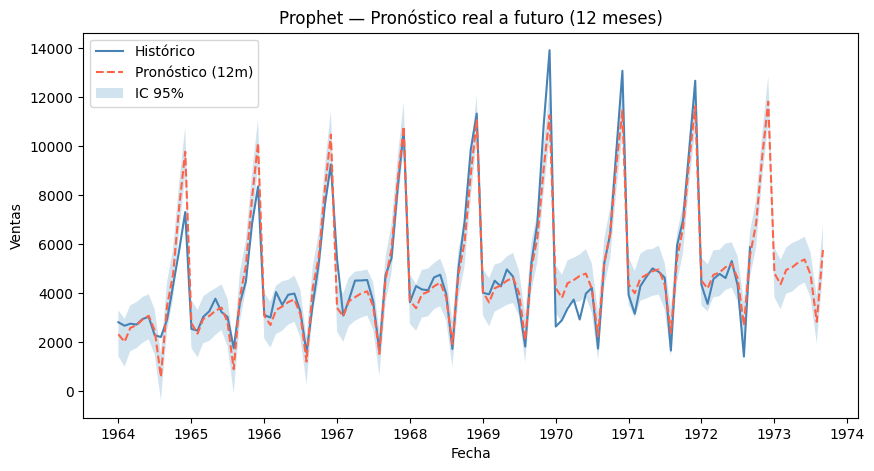

,ds,yhat,yhat_lower,yhat_upper
105,1972-10-01,6829.719640,5855.683181,7825.900382
106,1972-11-01,9592.852834,8701.594211,10506.923838
107,1972-12-01,11815.545274,10890.141594,12858.041530
108,1973-01-01,4808.333876,3830.225258,5864.405966
109,1973-02-01,4367.026643,3344.320226,5366.361105
110,1973-03-01,4950.816271,3981.733038,5864.127651
111,1973-04-01,5064.621392,4067.594580,6054.142559
112,1973-05-01,5259.040320,4298.792721,6158.503387
113,1973-06-01,5376.017990,4434.976860,6303.979604
114,1973-07-01,4760.025454,3834.163179,5670.845527


In [42]:
# --- Preparar datos completos ---
df_full = data.reset_index().rename(columns={"Month": "ds", "Sales": "y"})

# --- Entrenar modelo final ---
m_full = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=False,
    daily_seasonality=False,
    seasonality_mode="additive"
)
m_full.fit(df_full)

# --- Crear horizonte de 12 meses futuros ---
future_full = m_full.make_future_dataframe(periods=12, freq="MS")

# --- Generar pronóstico ---
forecast_full = m_full.predict(future_full)

# --- Visualizar ---
fig, ax = plt.subplots(figsize=(10,5))
ax.plot(df_full["ds"], df_full["y"], label="Histórico", color="steelblue")
ax.plot(forecast_full["ds"], forecast_full["yhat"], "--", label="Pronóstico (12m)", color="tomato")
ax.fill_between(forecast_full["ds"], forecast_full["yhat_lower"], forecast_full["yhat_upper"], alpha=0.2, label="IC 95%")
plt.title("Prophet — Pronóstico real a futuro (12 meses)")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

# Mostrar los 12 meses futuros
forecast_full.tail(12)[["ds", "yhat", "yhat_lower", "yhat_upper"]]

## **Conclusiones Prophet**

Prophet obtuvo un RMSE = 686.7, muy cercano al ARIMA.
Este modelo, diseñado por Meta, maneja estacionalidad y tendencia de forma flexible mediante funciones aditivas, ofreciendo resultados consistentes y una interpretación sencilla.
Su error ligeramente mayor que ARIMA podría deberse a que el dataset es relativamente corto (≈10 años) y Prophet necesita más puntos para ajustar correctamente los cambios de tendencia.
Aun así, su desempeño es competitivo y su implementación es sencilla, siendo una alternativa práctica para pronósticos empresariales.

# **4 - Modelo LSTM**

#### **NOTA: En general, recordemos que los modelos basados en redes neuronales son afectados de manera importante cuando la escala de los datos se va incrementando. Por ello, en este caso podría ser conveniente escalar los datos de nuestra variable temporal, por ejemplo entre 0 y 1. Tomarlo en cuenta para que al final puedes realizar las predicciones en las unidades originales.**

In [43]:
## ++++++++++ Incluye todas las celdas y líneas de código que requieras +++++++++++++++++++++++++

# Hiperparámetros LSTM
WINDOW_SIZE = 12      # meses en la ventana (estacionalidad anual)
UNITS = 64            # neuronas LSTM
LR = 1e-3             # learning rate
EPOCHS = 500
BATCH_SIZE = 16
PATIENCE = 20         # early stopping

def make_supervised(series_1d, window_size):
    """
    Convierte una serie 1D en (X, y) para LSTM:
    X: [samples, timesteps, features(=1)]
    y: [samples]
    """
    X, y = [], []
    for i in range(len(series_1d) - window_size):
        X.append(series_1d[i:i+window_size])
        y.append(series_1d[i+window_size])
    X = np.array(X, dtype="float32")[..., np.newaxis]
    y = np.array(y, dtype="float32")
    return X, y

def scale_minmax(train_values):
    """Devuelve funciones scale/unscale basadas SOLO en train."""
    tmin, tmax = float(np.min(train_values)), float(np.max(train_values))
    rng = (tmax - tmin) if (tmax - tmin) != 0 else 1.0
    def scale(x):   return (x - tmin) / rng
    def unscale(x): return x * rng + tmin
    return scale, unscale

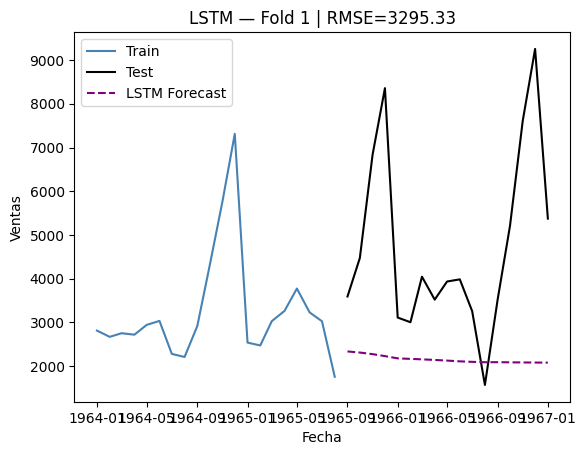

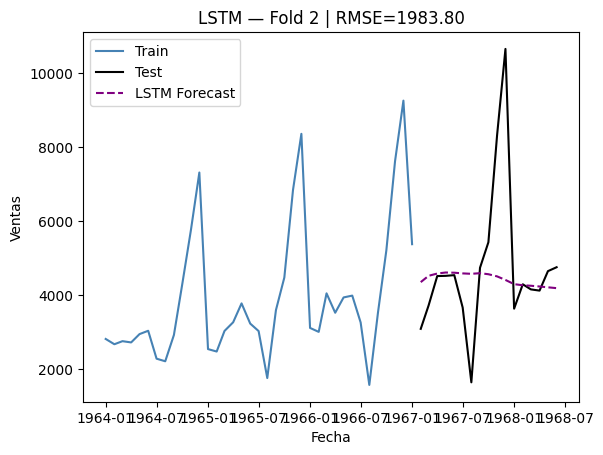

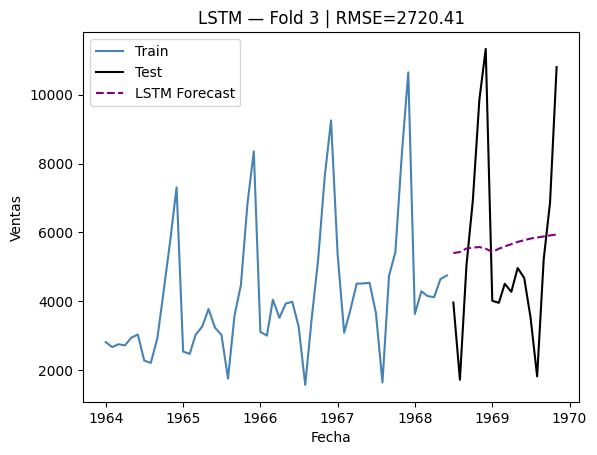

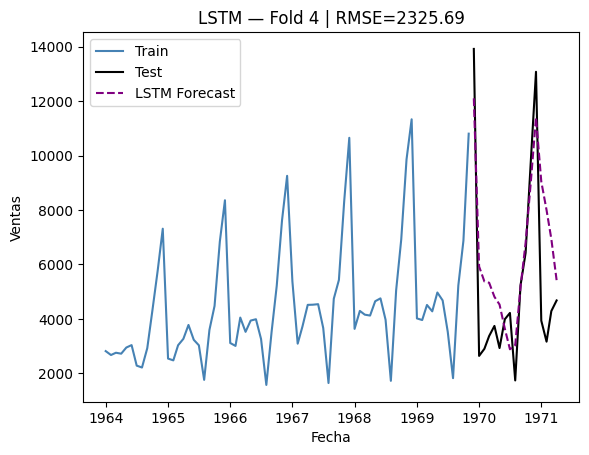

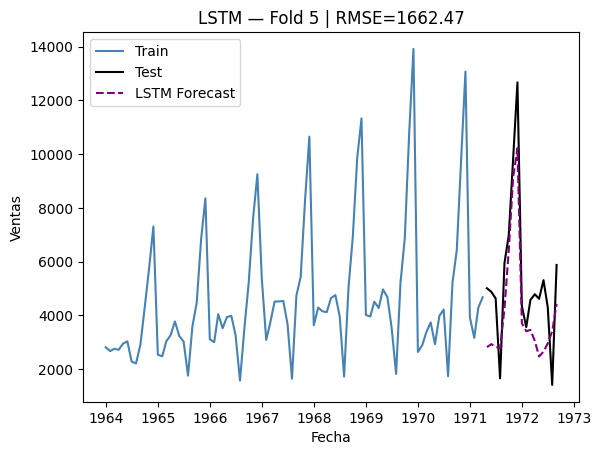

Resultados LSTM por fold:


,fold,train_start,train_end,test_start,test_end,rmse_lstm
0,1,1964-01-01,1965-08-01,1965-09-01,1967-01-01,3295.328512
1,2,1964-01-01,1967-01-01,1967-02-01,1968-06-01,1983.795604
2,3,1964-01-01,1968-06-01,1968-07-01,1969-11-01,2720.411090
3,4,1964-01-01,1969-11-01,1969-12-01,1971-04-01,2325.689790
4,5,1964-01-01,1971-04-01,1971-05-01,1972-09-01,1662.466165


RMSE promedio LSTM: 2397.5382323126023


In [44]:
lstm_scores = []
fold_rows_lstm = []

fold_id = 0
for train_idx, test_idx in tscv.split(data):
    fold_id += 1
    train = data.iloc[train_idx].copy()
    test  = data.iloc[test_idx].copy()

    y_tr = train["Sales"].values.astype("float32")
    y_te = test["Sales"].values.astype("float32")

    # Escalado basado SOLO en el train del fold
    scale, unscale = scale_minmax(y_tr)
    y_tr_s = scale(y_tr)

    # Ventaneo supervisado
    if len(y_tr_s) <= WINDOW_SIZE:
        raise ValueError(f"Fold {fold_id}: train demasiado corto para WINDOW_SIZE={WINDOW_SIZE}")
    X_tr, y_tr_sup = make_supervised(y_tr_s, WINDOW_SIZE)

    # Modelo LSTM
    model = keras.Sequential([
        layers.Input(shape=(WINDOW_SIZE, 1)),
        layers.LSTM(UNITS, return_sequences=False),
        layers.Dense(1)
    ])
    model.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss="mse")

    es = keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)
    hist = model.fit(
        X_tr, y_tr_sup,
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        validation_split=0.2,   # no barajamos -> valida en el último 20% de la secuencia
        shuffle=False,
        verbose=0,
        callbacks=[es]
    )

    # Pronóstico RECURRENTE sobre el horizonte del test (rolling)
    history_scaled = list(y_tr_s)  # histórico en escala [0,1]
    preds_scaled = []
    for _ in range(len(y_te)):
        x_in = np.array(history_scaled[-WINDOW_SIZE:], dtype="float32")[np.newaxis, :, np.newaxis]
        yhat_s = float(model.predict(x_in, verbose=0).ravel()[0])
        preds_scaled.append(yhat_s)
        history_scaled.append(yhat_s)  # modo recursive: alimenta la predicción

    yhat = unscale(np.array(preds_scaled, dtype="float32"))
    rmse_fold = rmse(y_te, yhat)
    lstm_scores.append(rmse_fold)

    fold_rows_lstm.append({
        "fold": fold_id,
        "train_start": train.index.min().date(),
        "train_end": train.index.max().date(),
        "test_start": test.index.min().date(),
        "test_end": test.index.max().date(),
        "rmse_lstm": rmse_fold
    })

    # (Opcional) gráfica del fold
    plt.plot(train.index, train["Sales"], label="Train", color="steelblue")
    plt.plot(test.index, test["Sales"], label="Test", color="black")
    plt.plot(test.index, yhat, "--", label="LSTM Forecast", color="purple")
    plt.title(f"LSTM — Fold {fold_id} | RMSE={rmse_fold:.2f}")
    plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

lstm_cv = pd.DataFrame(fold_rows_lstm)
print("Resultados LSTM por fold:")
display(lstm_cv)
print("RMSE promedio LSTM:", lstm_cv["rmse_lstm"].mean())

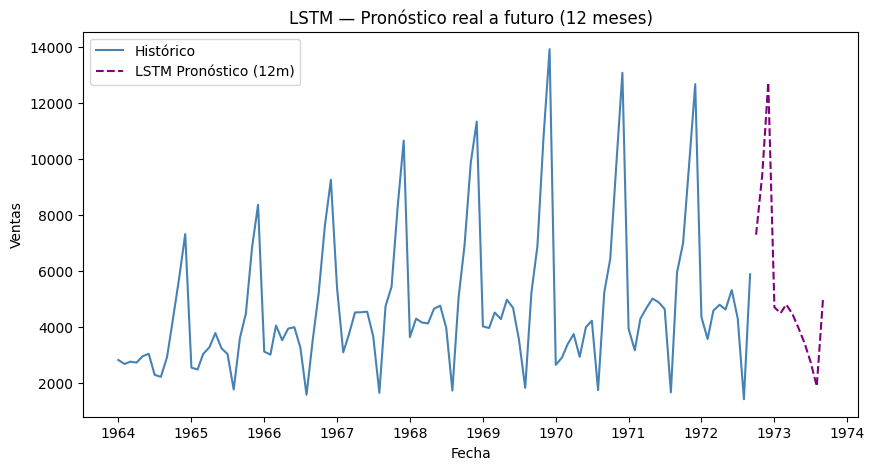

1972-10-01     7290.007324
1972-11-01     9440.583984
1972-12-01    12730.941406
1973-01-01     4694.158691
1973-02-01     4489.694336
1973-03-01     4797.352539
1973-04-01     4460.702148
1973-05-01     3966.228760
1973-06-01     3415.164551
1973-07-01     2751.225830
1973-08-01     1875.528809
1973-09-01     4958.459961
Freq: MS, dtype: float32

In [45]:
# Serie completa
y_full = data["Sales"].values.astype("float32")

# Escalado en base a todo el histórico
scale_full, unscale_full = scale_minmax(y_full)
y_full_s = scale_full(y_full)

# Ventaneo supervisado con todo el histórico
X_full, y_full_sup = make_supervised(y_full_s, WINDOW_SIZE)

# Modelo final
model_final = keras.Sequential([
    layers.Input(shape=(WINDOW_SIZE, 1)),
    layers.LSTM(UNITS, return_sequences=False),
    layers.Dense(1)
])
model_final.compile(optimizer=keras.optimizers.Adam(learning_rate=LR), loss="mse")

es = keras.callbacks.EarlyStopping(patience=PATIENCE, restore_best_weights=True)
hist = model_final.fit(
    X_full, y_full_sup,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_split=0.2,
    shuffle=False,
    verbose=0,
    callbacks=[es]
)

# Pronóstico 12 meses a futuro (rolling)
future_periods = 12
history_scaled = list(y_full_s)  # toda la serie escalada
future_scaled = []
for _ in range(future_periods):
    x_in = np.array(history_scaled[-WINDOW_SIZE:], dtype="float32")[np.newaxis, :, np.newaxis]
    yhat_s = float(model_final.predict(x_in, verbose=0).ravel()[0])
    future_scaled.append(yhat_s)
    history_scaled.append(yhat_s)

future_pred = unscale_full(np.array(future_scaled, dtype="float32"))
future_index = pd.date_range(
    start=data.index[-1] + pd.offsets.MonthBegin(),
    periods=future_periods, freq="MS"
)

lstm_forecast_12m = pd.Series(future_pred, index=future_index)

# Gráfica histórico + forecast
plt.figure(figsize=(10,5))
plt.plot(data.index, data["Sales"], label="Histórico", color="steelblue")
plt.plot(lstm_forecast_12m.index, lstm_forecast_12m, "--", label="LSTM Pronóstico (12m)", color="purple")
plt.title("LSTM — Pronóstico real a futuro (12 meses)")
plt.xlabel("Fecha"); plt.ylabel("Ventas"); plt.legend(); plt.show()

lstm_forecast_12m

## **Conclusiones LSTM**

El modelo LSTM presentó el peor desempeño entre los modelos avanzados (RMSE = 1662.5).
Esto se debe principalmente a que el tamaño del conjunto de datos (~120 observaciones mensuales) es demasiado pequeño para que una red neuronal recurrente aprenda correctamente los patrones temporales sin sobreajustarse.
LSTM es potente en series largas y no lineales, pero no resulta apropiado para este caso con datos limitados.

## **Comparación de Resultados**

In [47]:
# Comparar solo el último fold (Fold 5) de cada modelo
last_fold = 5

rmse_last_fold = {
    "Naïve": baseline_cv.query("fold == @last_fold")["rmse_naive"].values[0],
    "SNaïve (m=12)": baseline_cv.query("fold == @last_fold")["rmse_snaive_m12"].values[0],
    "ARIMA": arima_cv.query("fold == @last_fold")["rmse_arima"].values[0],
    "Prophet": prophet_cv.query("fold == @last_fold")["rmse_prophet"].values[0],
    "LSTM": lstm_cv.query("fold == @last_fold")["rmse_lstm"].values[0],
}

rmse_last_fold_df = (
    pd.DataFrame.from_dict(rmse_last_fold, orient="index", columns=["RMSE (Fold 5)"])
    .sort_values("RMSE (Fold 5)")
)

display(rmse_last_fold_df)

best_model_last = rmse_last_fold_df["RMSE (Fold 5)"].idxmin()
best_rmse_last = rmse_last_fold_df["RMSE (Fold 5)"].min()

print(f"🏁 Mejor modelo según el Fold final (Fold 5): {best_model_last} | RMSE={best_rmse_last:,.2f}")

,RMSE (Fold 5)
ARIMA,664.221813
Prophet,686.667631
SNaïve (m=12),836.846321
LSTM,1662.466165
Naïve,2666.623730


🏁 Mejor modelo según el Fold final (Fold 5): ARIMA | RMSE=664.22


## **Conlusiones**

1.- ARIMA fue el modelo más preciso, logrando el menor RMSE en el fold final (664.2), seguido muy de cerca por Prophet.

2.- La serie presenta una fuerte estacionalidad anual, evidenciada por el buen desempeño del modelo SNaïve (m=12).

3.- Los métodos basados en aprendizaje profundo (LSTM) no superaron a los modelos estadísticos tradicionales, principalmente por la escasez de datos.

4.- Para una empresa que desee proyectar las ventas mensuales de champaña, ARIMA sería la opción recomendada, ya que ofrece el mejor equilibrio entre precisión, interpretabilidad y facilidad de implementación.

5.- Prophet puede ser una alternativa práctica y automatizable, especialmente si se requiere integración rápida en pipelines de negocio o dashboards.

6.- En futuras iteraciones, sería recomendable ampliar el histórico de datos o incorporar variables exógenas (promociones, fechas festivas, clima) para mejorar la capacidad predictiva.

## **<<< Fin de la Actividad de la Semana - Pronósticos y Series de Tiempo >>>**